<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Unsupervised%20Learning/Dimensionality%20reduction/BitcoinTradingEnhancingSpeedAccuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reducción de la dimensionalidad-Problema de predicción del precio del bitcoin

En este proyecto, utilizaremos el enfoque de reducción de la dimensionalidad para el problema de predicción del precio del bitcoin.



## Contenido

* [1. Definición del problema](#0)
* [2. Inicio - Cargar bibliotecas y conjunto de datos](#1)
    * [2.1. Cargar Bibliotecas](#1.1)    
    * [2.2. Cargar el conjunto de datos](#1.2)
* [3. Análisis exploratorio de datos](#2)
    * [3.1. Estadísticas descriptivas](#2.1) 
* [4. Preparación de los datos](#3)
    * [4.1. Limpieza de datos](#3.1)
    * [4.2. Preparación de los datos de clasificación](#3.2)
    * [4.3. Ingeniería de rasgos-Construcción de indicadores técnicos](#3.3)
    * [4.4.Visualización de datos](#3.4)
* [5.Evaluar algoritmos y modelos](#4)        
    * [5.1. División tren/prueba](#4.1)
    * [5.2. Descomposición de valores singulares (reducción de características)](#4.2)
    * [5.3. Visualización t-SNE](#4.3) 
    * [5.3. Comparar modelos-con y sin reducción de la dimensionalidad](#4.4) 


<a id='0'></a>
# 1. Definición del problema

En este proyecto, utilizaremos el enfoque de reducción de la dimensionalidad para "estrategia de comercio de bitcoins".
Los datos y las variables utilizadas en este proyecto son los datos de bitcoin para el período de tiempo de enero de 2012 a marzo de 2021, con actualizaciones minuto a minuto de OHLC (Open, High, Low, Close), Volumen en BTC y moneda indicada y precio ponderado de bitcoin.

<a id='1'></a>
# 2. Primeros pasos - Cargar los datos y los paquetes de Python

<a id='1.1'></a>
## 2.1. Carga de los paquetes python

In [1]:
# Carga de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

from mpl_toolkits.mplot3d import Axes3D

import re
from collections import OrderedDict
from time import time
import sqlite3       

from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed

<a id='1.2'></a>
## 2.2. Loading the Data

In [2]:
dataset = pd.read_csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [3]:
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Análisis exploratorio de datos

<a id='2.1'></a>
## 3.1. Estadísticas descriptivas

In [4]:
# shape
dataset.shape

(4857377, 8)

In [5]:
# consultar los datos
set_option('display.width', 100)
dataset.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


In [6]:
# describir los datos
set_option('precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857e+06,3.614e+06,3.614e+06,3.614e+06,3.614e+06,3.614e+06,3.614e+06,3.614e+06
mean,1.471e+09,6.009e+03,6.013e+03,6.004e+03,6.009e+03,9.323e+00,4.176e+04,6.009e+03
std,8.428e+07,8.996e+03,9.004e+03,8.989e+03,8.996e+03,3.055e+01,1.518e+05,8.996e+03
min,1.325e+09,3.800e+00,3.800e+00,1.500e+00,1.500e+00,0.000e+00,0.000e+00,3.800e+00
25%,1.398e+09,4.439e+02,4.440e+02,4.435e+02,4.439e+02,4.098e-01,4.521e+02,4.438e+02
50%,1.471e+09,3.597e+03,3.598e+03,3.596e+03,3.597e+03,1.980e+00,3.810e+03,3.597e+03
75%,1.544e+09,8.627e+03,8.633e+03,8.621e+03,8.627e+03,7.278e+00,2.570e+04,8.628e+03
max,1.617e+09,6.176e+04,6.178e+04,6.167e+04,6.178e+04,5.854e+03,1.390e+07,6.172e+04


<a id='3'></a>
# 4. Preparación de datos

<a id='3.1'></a>
## 4.1. Limpieza de datos

In [7]:
# Comprobación de los valores nulos y eliminación de los mismos'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Dado que hay valores nulos, tenemos que limpiar los datos rellenando los *NaNs* con los últimos valores disponibles. 

In [8]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [9]:
dataset=dataset.drop(columns=['Timestamp'])

<a id='3.2'></a>
## 4.2. Preparación de los datos para su clasificación

Atribuimos una etiqueta a cada movimiento: 

**1** si la señal es que el precio a corto plazo subirá en comparación con el largo plazo. 

**0** si la señal es que el precio a corto plazo bajará en comparación con el largo plazo.

In [10]:
# Inicializar el DataFrame `signals` con la columna `signal`.
# datas['PriceMove'] = 0.0

# Crear una media móvil simple corta sobre la ventana corta
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Crear una media móvil simple larga sobre la ventana larga
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Crear señales
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [11]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
4857372,58714.31,58714.31,58686.00,58686.00,1.384,81259.372,58692.753,58695.262,58667.759,1.0
4857373,58683.97,58693.43,58683.97,58685.81,7.295,428158.147,58693.227,58693.564,58667.410,1.0
4857374,58693.43,58723.84,58693.43,58723.84,1.706,100117.070,58696.198,58698.178,58667.708,1.0
4857375,58742.18,58770.38,58742.18,58760.59,0.720,42332.959,58761.866,58709.824,58668.532,1.0
4857376,58767.75,58778.18,58755.97,58778.18,2.713,159417.751,58764.349,58718.698,58670.551,1.0


<a id='3.3'></a>
## 4.3. Ingeniería de caracteristicas

Realizamos ingeniería de características para construir los indicadores técnicos que se utilizarán para hacer las predicciones, y la variable de salida.

Los datos actuales del bicoin consisten en la fecha, la apertura, el máximo, el mínimo, el cierre y el volumen. Con estos datos calculamos los siguientes indicadores técnicos:
* **Media móvil** : Una media móvil proporciona una indicación de la tendencia del movimiento del precio recortando la cantidad de "ruido" en un gráfico de precios. 
**Oscilador estocástico %K y %D** : Un oscilador estocástico es un indicador de impulso que compara un precio de cierre concreto de un valor con un rango de sus precios durante un periodo de tiempo determinado. El %K y el %D son indicadores lentos y rápidos.
* **Índice de Fuerza Relativa(RSI)** :Es un indicador de impulso que mide la magnitud de los cambios recientes en el precio para evaluar las condiciones de sobrecompra o sobreventa en el precio de una acción u otro activo. 
* **Tasa de Cambio(ROC)**: Es un oscilador de momentum, que mide el cambio porcentual entre el precio actual y el precio pasado de n períodos. 
* **Momentum (MOM)** : Es la tasa de aceleración del precio o del volumen de un valor, es decir, la velocidad a la que cambia el precio.

In [12]:
# cálculo de la media móvil exponencial
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

# cálculo de la tasa de variación
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

# Cálculo del impulso de los precios
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

# cálculo del índice de fuerza relativa
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) # el primer valor es la suma de las ganancias medias
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) # el primer valor es la suma de las pérdidas medias
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

# cálculo del osilador estocástico.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [13]:
# Cálculo de la media móvil
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58714.31,58714.31,58686.00,58686.00,1.384,81259.372,58692.753,58695.262,58667.759,1.0,...,49.479,35.393,61.578,51.697,68.138,39.264,47.840,58695.262,58676.974,58717.263
4857373,58683.97,58693.43,58683.97,58685.81,7.295,428158.147,58693.227,58693.564,58667.410,1.0,...,49.478,35.232,44.602,51.583,57.317,34.155,39.806,58693.564,58675.469,58717.926
4857374,58693.43,58723.84,58693.43,58723.84,1.706,100117.070,58696.198,58698.178,58667.708,1.0,...,49.822,67.380,46.002,74.385,59.222,41.881,38.433,58698.178,58675.542,58718.662
4857375,58742.18,58770.38,58742.18,58760.59,0.720,42332.959,58761.866,58709.824,58668.532,1.0,...,50.153,91.131,64.581,94.261,73.410,51.701,42.579,58709.824,58675.947,58719.380
4857376,58767.75,58778.18,58755.97,58778.18,2.713,159417.751,58764.349,58718.698,58670.551,1.0,...,50.310,100.000,86.170,100.000,89.549,56.401,49.994,58718.698,58677.057,58720.382


In [14]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58714.31,58714.31,58686.00,58686.00,1.384,81259.372,58692.753,58695.262,58667.759,1.0,...,49.479,35.393,61.578,51.697,68.138,39.264,47.840,58695.262,58676.974,58717.263
4857373,58683.97,58693.43,58683.97,58685.81,7.295,428158.147,58693.227,58693.564,58667.410,1.0,...,49.478,35.232,44.602,51.583,57.317,34.155,39.806,58693.564,58675.469,58717.926
4857374,58693.43,58723.84,58693.43,58723.84,1.706,100117.070,58696.198,58698.178,58667.708,1.0,...,49.822,67.380,46.002,74.385,59.222,41.881,38.433,58698.178,58675.542,58718.662
4857375,58742.18,58770.38,58742.18,58760.59,0.720,42332.959,58761.866,58709.824,58668.532,1.0,...,50.153,91.131,64.581,94.261,73.410,51.701,42.579,58709.824,58675.947,58719.380
4857376,58767.75,58778.18,58755.97,58778.18,2.713,159417.751,58764.349,58718.698,58670.551,1.0,...,50.310,100.000,86.170,100.000,89.549,56.401,49.994,58718.698,58677.057,58720.382


In [15]:
# excluyendo las columnas que no son necesarias para nuestra predicción.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [16]:
dataset = dataset.dropna(axis=0)

In [17]:
dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58686.00,1.384,58692.753,1.0,58691.231,58675.538,58722.003,-0.029,-0.077,19.46,...,49.479,35.393,61.578,51.697,68.138,39.264,47.840,58695.262,58676.974,58717.263
4857373,58685.81,7.295,58693.227,1.0,58690.246,58676.201,58721.643,0.014,-0.061,-16.98,...,49.478,35.232,44.602,51.583,57.317,34.155,39.806,58693.564,58675.469,58717.926
4857374,58723.84,1.706,58696.198,1.0,58696.354,58679.274,58721.665,0.136,-0.042,46.14,...,49.822,67.380,46.002,74.385,59.222,41.881,38.433,58698.178,58675.542,58718.662
4857375,58760.59,0.720,58761.866,1.0,58708.033,58684.520,58722.052,0.121,0.027,116.46,...,50.153,91.131,64.581,94.261,73.410,51.701,42.579,58709.824,58675.947,58719.380
4857376,58778.18,2.713,58764.349,1.0,58720.787,58690.563,58722.610,0.133,0.072,88.74,...,50.310,100.000,86.170,100.000,89.549,56.401,49.994,58718.698,58677.057,58720.382


<a id='3.4'></a>
## 4.4. Visualización de datos

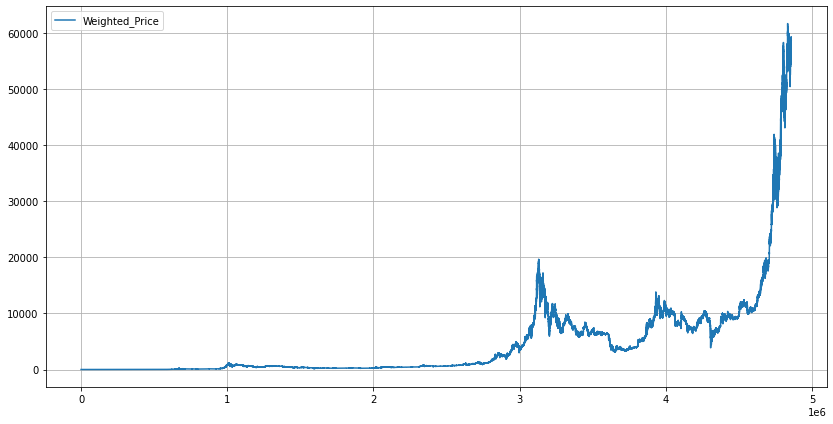

In [18]:
dataset[['Weighted_Price']].plot(grid=True, figsize=(14,7))
plt.show()

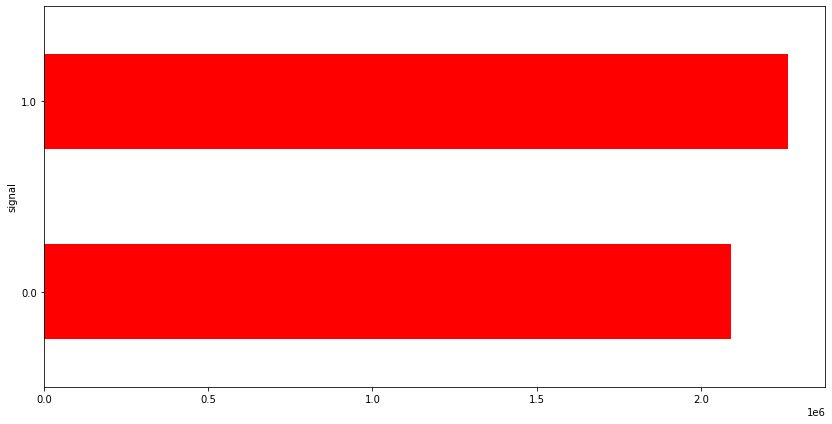

In [43]:
fig = plt.figure(figsize=(14,7))
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

La variable pronosticada es ascendente en un 52,87% del tamaño total de los datos, lo que significa que el número de señales de compra fue mayor que el de señales de venta.

<a id='4'></a>
# 5. Evaluar algoritmos y modelos

<a id='4.1'></a>
## 5.1. Train Test Split

Dividimos el conjunto de datos en un 80% de entrenamiento y un 20% de prueba.

In [20]:
# dividir el conjunto de datos de validación para el final
subset_dataset= dataset.iloc[-10000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

### Normalización de datos
Como paso de preprocesamiento, vamos a empezar por normalizar los valores de las características para que estén estandarizados - esto hace que las comparaciones sean más sencillas y permite los siguientes pasos para la Descomposición de Valores Singulares.

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)

# resumir los datos transformados
X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,Close,Volume_(BTC),Weighted_Price,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4850071,-1.263,1.621,-1.273,-1.278,-1.313,-1.463,0.664,0.612,0.516,0.872,...,0.595,0.655,0.906,0.973,1.203,1.304,1.354,-1.282,-1.312,-1.441
4852517,-0.324,-0.561,-0.318,-0.302,-0.306,-0.348,-0.080,-0.073,-0.371,0.034,...,-0.235,-1.469,-0.926,-0.522,0.051,0.521,0.644,-0.300,-0.302,-0.398


<a id='4.2'></a>
## 5.2. Descomposición de valores singulares (reducción de características)

Queremos reducir la dimensionalidad del problema para hacerlo más manejable, pero al mismo tiempo queremos preservar toda la información posible. 

Por lo tanto, utilizamos una técnica llamada descomposición del valor singular (SVD), que es una de las formas de realizar el PCA.La descomposición del valor singular (SVD) es una factorización de matrices comúnmente utilizada en el procesamiento de señales y la compresión de datos. Utilizamos el método TruncatedSVD del paquete sklearn.

Varianza conservada por los 5 primeros componentes = 93.59%


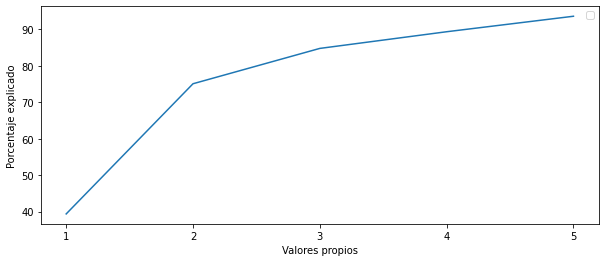

In [22]:
from matplotlib.ticker import MaxNLocator
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Valores propios")
ax.set_ylabel("Porcentaje explicado")
ax.legend("")
print('Varianza conservada por los 5 primeros componentes = {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

Podemos conservar el 93.59% de la varianza utilizando sólo 5 componentes en lugar de las más de 25 características originales.

In [23]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(8000, 5)


,c0,c1,c2,c3,c4
4850071,-0.924,4.837,-0.752,1.612,0.258
4852517,1.179,0.335,-1.597,-0.652,-0.034
4849945,0.040,4.699,-0.997,-0.089,-0.001
4851048,2.459,1.691,-1.734,0.282,-0.416
4854804,3.675,-2.039,0.046,-0.917,0.334


<a id='4.2.1'></a>
## 5.2.1. Visualización básica de características reducidas

Intentemos visualizar los datos con el conjunto de datos comprimido, representado por los 5 componentes principales de un SVD.

In [24]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

### Gráficos de pares
Los diagramas de pares son una representación sencilla que utiliza un conjunto de diagramas de dispersión en 2D, trazando cada componente contra otro componente y coloreando los puntos de datos según su clasificación (o tipo de señal).

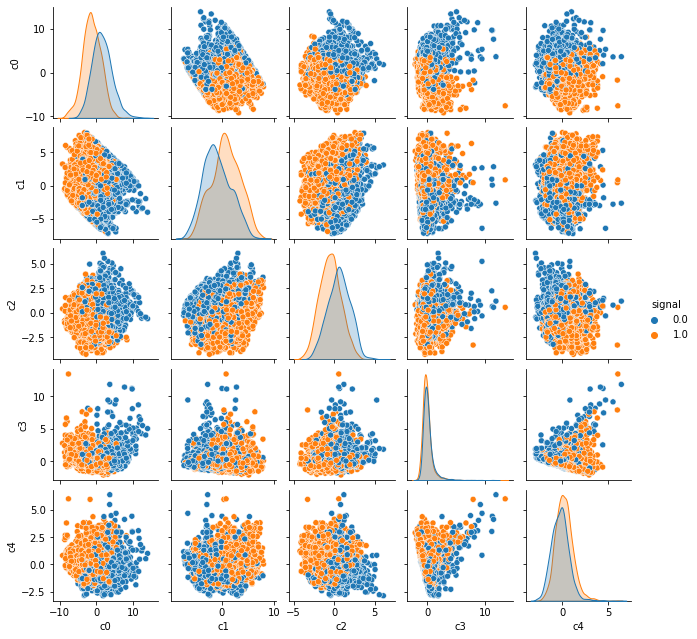

In [25]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['signal']=Y_train
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='signal', size=1.8)

__Observación__:

* En el gráfico de dispersión de cada uno de los componentes principales, podemos ver claramente que hay una clara segregación de los puntos naranja y azul, lo que significa que los puntos de datos del mismo tipo de señal tienden a agruparse.

* Sin embargo, es difícil obtener una apreciación completa de las diferencias y similitudes entre los puntos de datos de todos los componentes, lo que requiere que el lector mantenga comparaciones en su cabeza mientras ve

### Gráfico de dispersión en 3D
Como alternativa a los gráficos de pares, podemos ver un gráfico de dispersión en 3D, que al menos nos permite ver más dimensiones a la vez y posiblemente obtener una sensación interactiva de los datos

In [26]:
def scatter_3D(A, elevation=30, azimuth=120):
    
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

In [27]:
dfsvd['signal'] = Y_train
interactive(scatter_3D, A=fixed(dfsvd), elevation=30, azimuth=120)

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

__Observación__:

El paquete interactivo iPython Notebook nos permite crear un gráfico interactivo con controles de elevación y acimut
Podemos utilizar estos controles para cambiar interactivamente la vista de los 3 componentes superiores e investigar sus relaciones. Esto parece ciertamente más informativo que los gráficos de pares.

Sin embargo, seguimos sufriendo las mismas limitaciones importantes de los diagramas de pares, a saber, que perdemos gran parte de la varianza y tenemos que retener muchas cosas en la cabeza al visualizarlas.

<a id='4.3'></a>
## 5.3. Visualización t-SNE

En este paso, implementamos otra técnica de reducción de la dimensionalidad - t-SNE y observamos la visualización relacionada.Utilizaremos la implementación básica disponible en scikit-learn

In [28]:
tsne = TSNE(n_components=2, random_state=0)

In [29]:
Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

In [30]:
dftsne['signal'] = Y_train

Text(0.5, 1.0, 'Diagrama de dispersión de un conjunto de datos de múltiples dimensiones reducido a 2D mediante t-SNE')

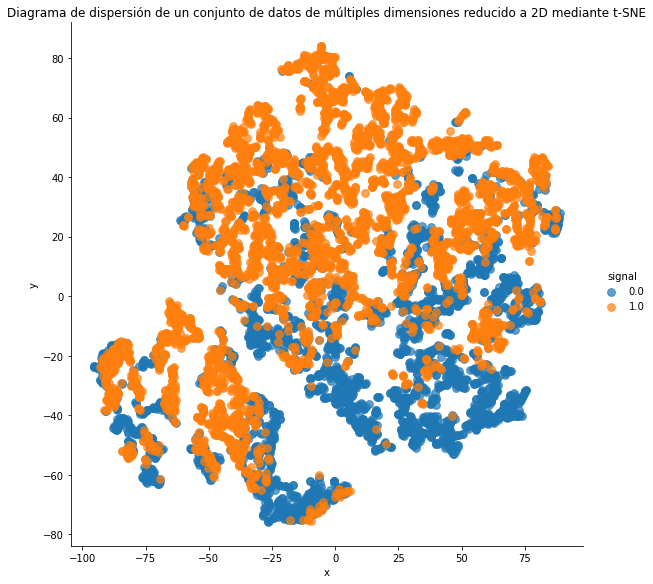

In [31]:
g = sns.lmplot('x', 'y', dftsne, hue='signal', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Diagrama de dispersión de un conjunto de datos de múltiples dimensiones reducido a 2D mediante t-SNE')

__Observación__:

Esta es una forma bastante interesante de visualizar los datos de la señal de trading. El gráfico anterior nos muestra que hay un buen grado de agrupación para la señal de comercio. Aunque hay algunos solapamientos entre las señales largas y cortas, se pueden distinguir bastante bien utilizando el número reducido de características. 



En revisión:

Hemos analizado el conjunto de datos de la señal de comercio de bitcoin en los siguientes pasos:

* Preparamos los datos mediante la limpieza (eliminación de valores de características de caracteres, sustitución de nans) y la normalización.
* Aplicamos la transformación durante la etapa de reducción de características.
* Luego visualizamos los datos en la dimensionalidad reducida y finalmente aplicamos el algoritmo t-SNE para reducir los datos en dos dimensiones y visualizarlos eficazmente

<a id='4.4'></a>
## 5.4. Comparar los modelos con y sin reducción de la dimensionalidad


In [32]:
# opciones de prueba para la clasificación
scoring = 'accuracy'

<a id='4.3.1'></a>
### 5.3.1. Modelos

In [33]:
import time
start_time = time.time()

In [39]:
# comprobar los algoritmos al azar

from sklearn.ensemble import RandomForestClassifier
kfold = 10


models =  RandomForestClassifier()
cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
print("Tiempo sin reducción de la dimensionalidad--- %s segundos ---" % (time.time() - start_time))

Tiempo sin reducción de la dimensionalidad--- 506.3359498977661 segundos ---


In [41]:
start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Tiempo con reducción de la dimensionalidad--- %s segundos ---" % (time.time() - start_time))

Tiempo con reducción de la dimensionalidad--- 14.629241943359375 segundos ---


In [42]:
print("Resultado sin reducción de la dimensionalidad: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Resultado con reducción de la dimensionalidad: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Resultado sin reducción de la dimensionalidad: 0.935375 (0.005094)
Resultado con reducción de la dimensionalidad: 0.886750 (0.005921)


Si observamos los resultados del modelo, no nos desviamos mucho de la precisión, y ésta sólo disminuye del 93,6% al 88,7%. Sin embargo, hay una mejora de 4 veces en el tiempo empleado, lo cual es significativo.

__Conclusión__:


Con la reducción de la dimensionalidad, logramos casi la misma precisión con una mejora de cuatro veces en el tiempo. En el desarrollo de estrategias de negociación, cuando los conjuntos de datos son enormes y el número de características es grande, esta mejora en el tiempo puede conducir a una mejora significativa en todo el proceso. 

Demostramos que tanto el SVD como el t-SNE proporcionan una forma bastante interesante de visualizar los datos de las señales de trading, y proporcionan una forma de distinguir las señales largas y cortas de una estrategia de trading con un número reducido de características.
